In [1]:
### Benjamin Tollison ###
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi

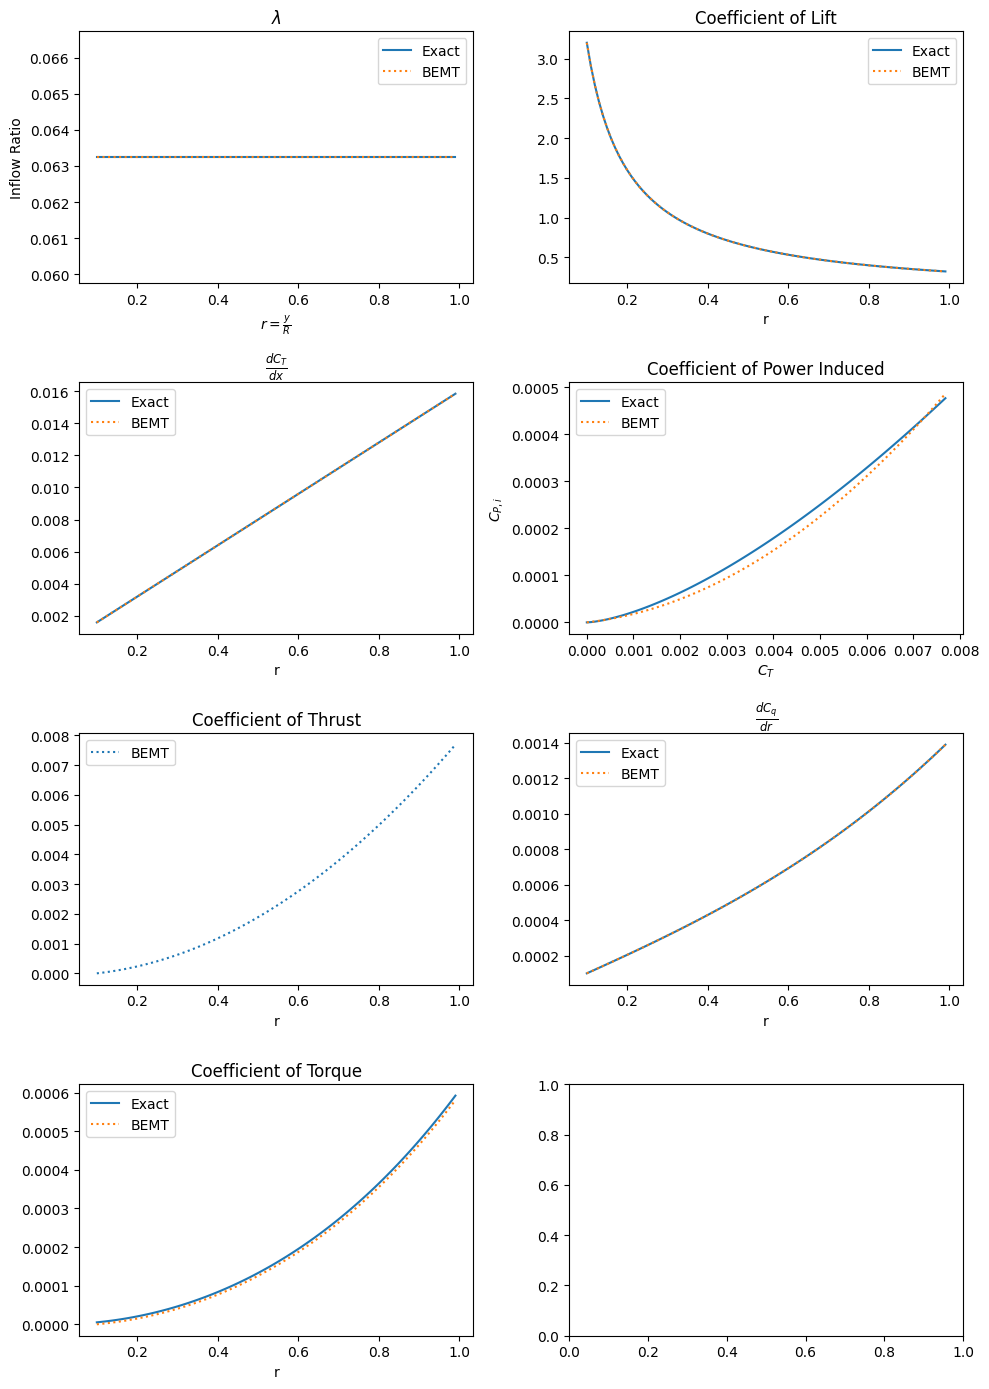

In [2]:
from Problem1 import SubPlotProblem1
from Problem2 import PlotProblem2,power_factor_no_tip_loss,power_factor_two_blades,power_factor_four_blades
from Problem3 import PlotProblem3
from Problem4 import PlotProblem4
from Problem5 import PlotProblem5,FigureOfMerit3DPlot
SubPlotProblem1() 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

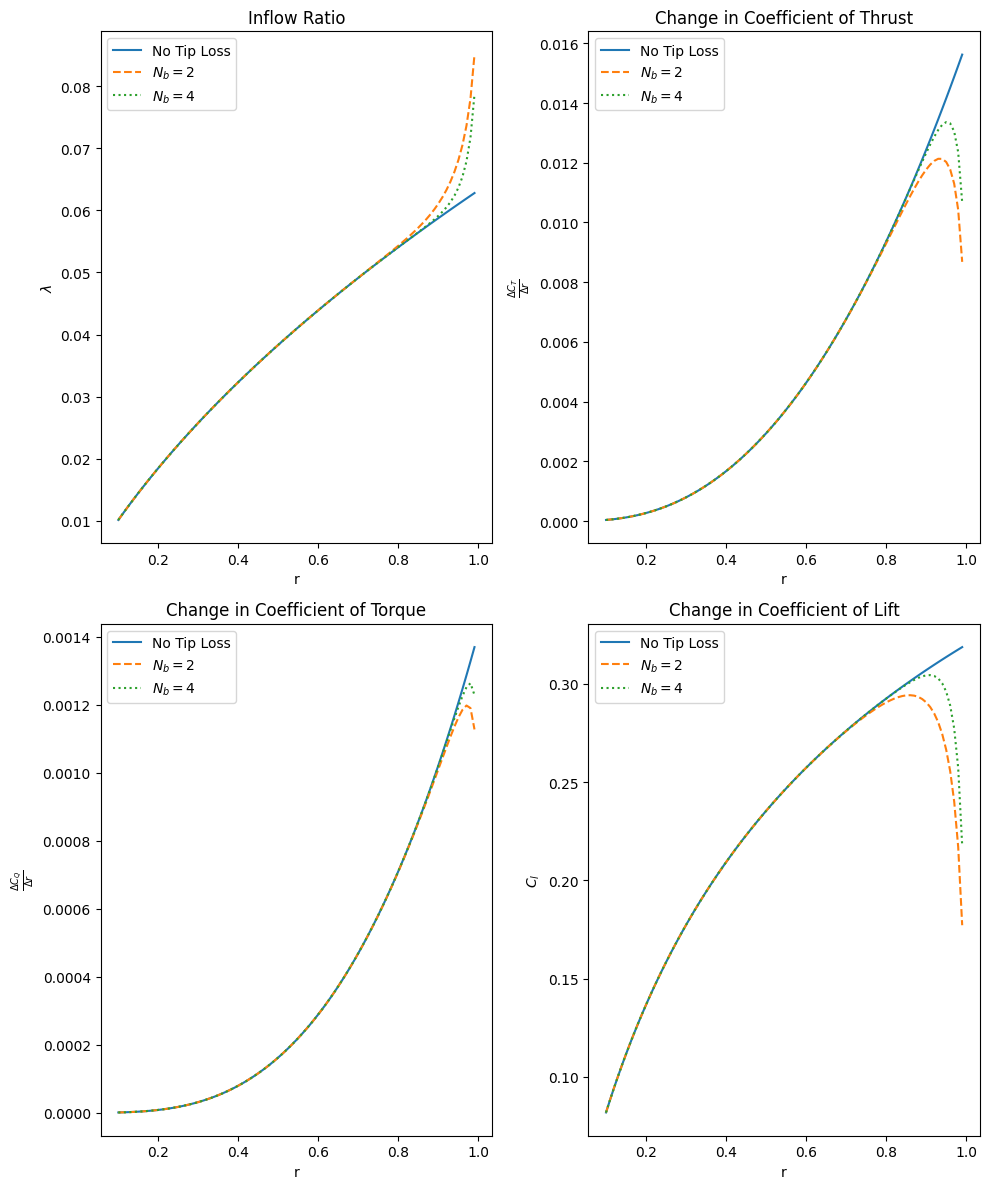

In [3]:
displayVariable('\\kappa_{notiploss}',power_factor_no_tip_loss)
displayVariable('\\kappa_{n_b=2}',power_factor_two_blades)
displayVariable('\\kappa_{n_b=4}',power_factor_four_blades)
PlotProblem2()

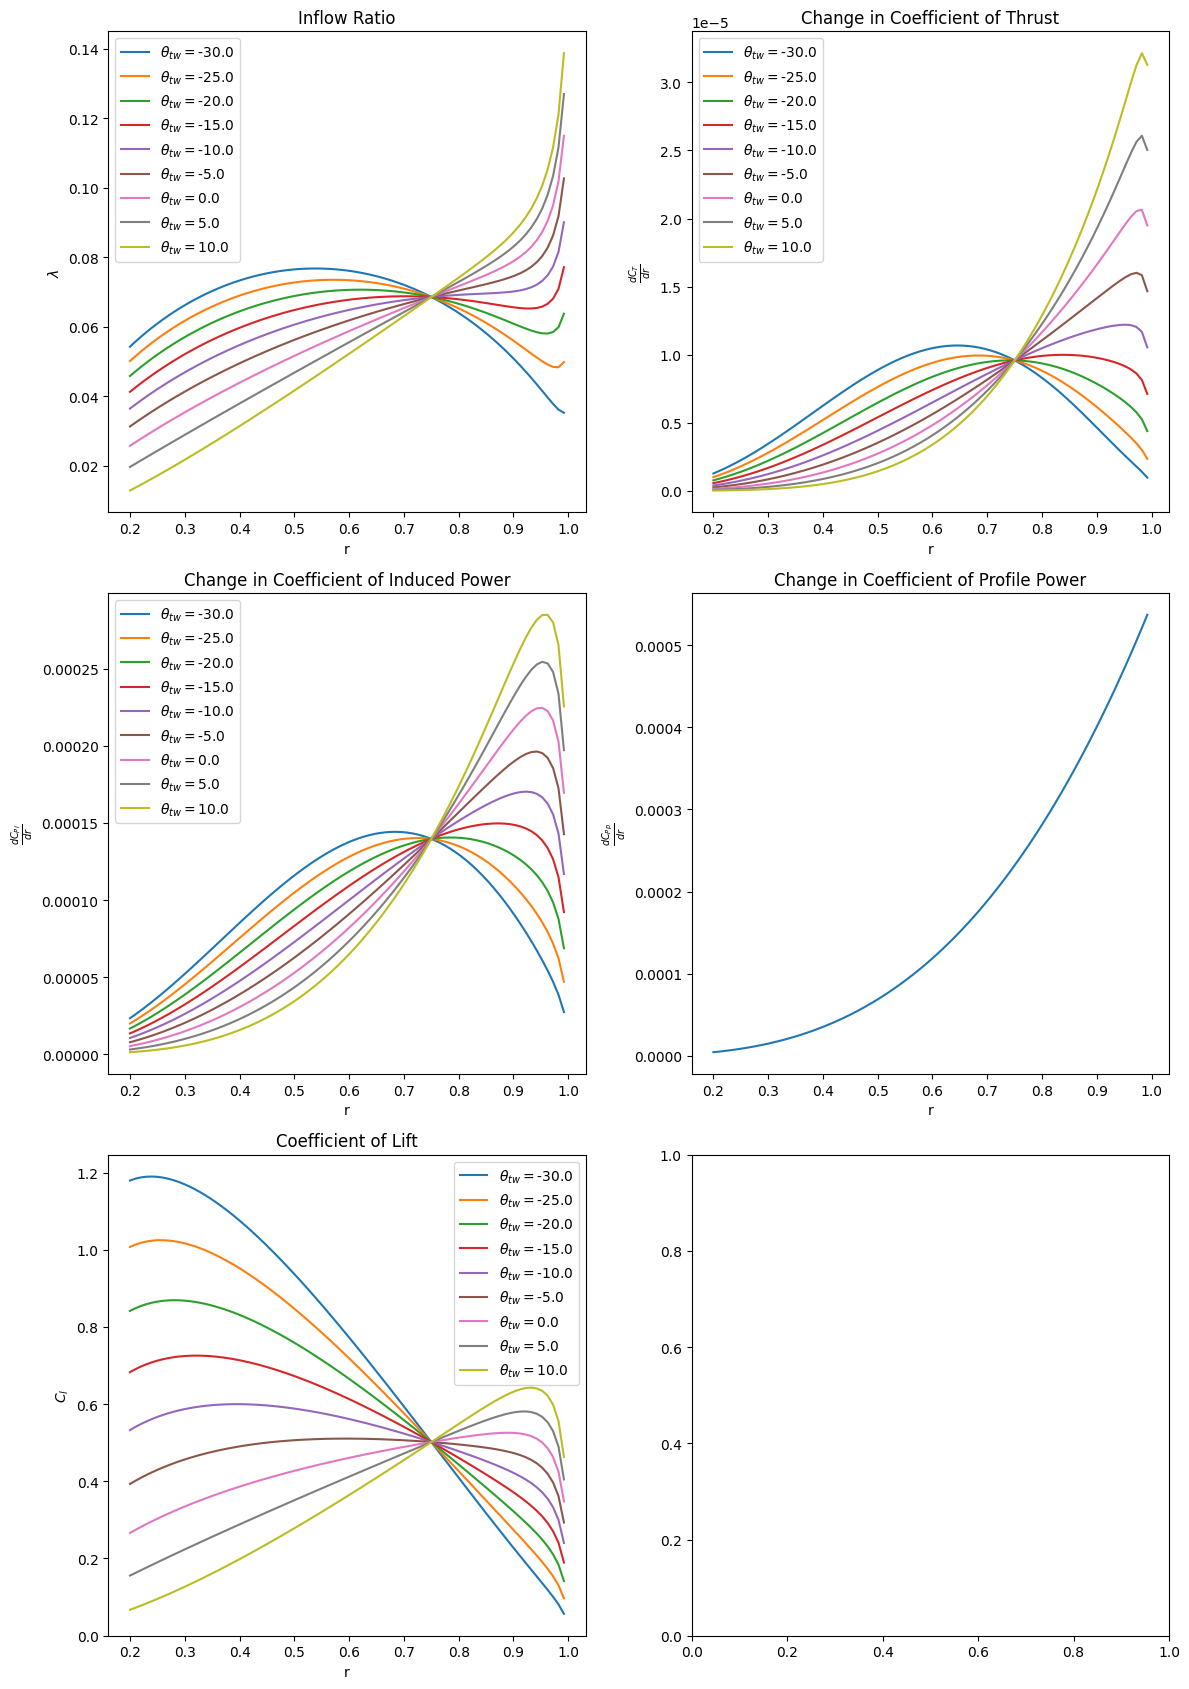

In [4]:
PlotProblem3()

/home/bigchungus/Documents/Github/School24/Aero 455/hw-3/Problem4.py:114: RuntimeWarning: invalid value encountered in scalar divide
  power_factor = (Cp_i * 2**0.5) / (Ct**1.5)


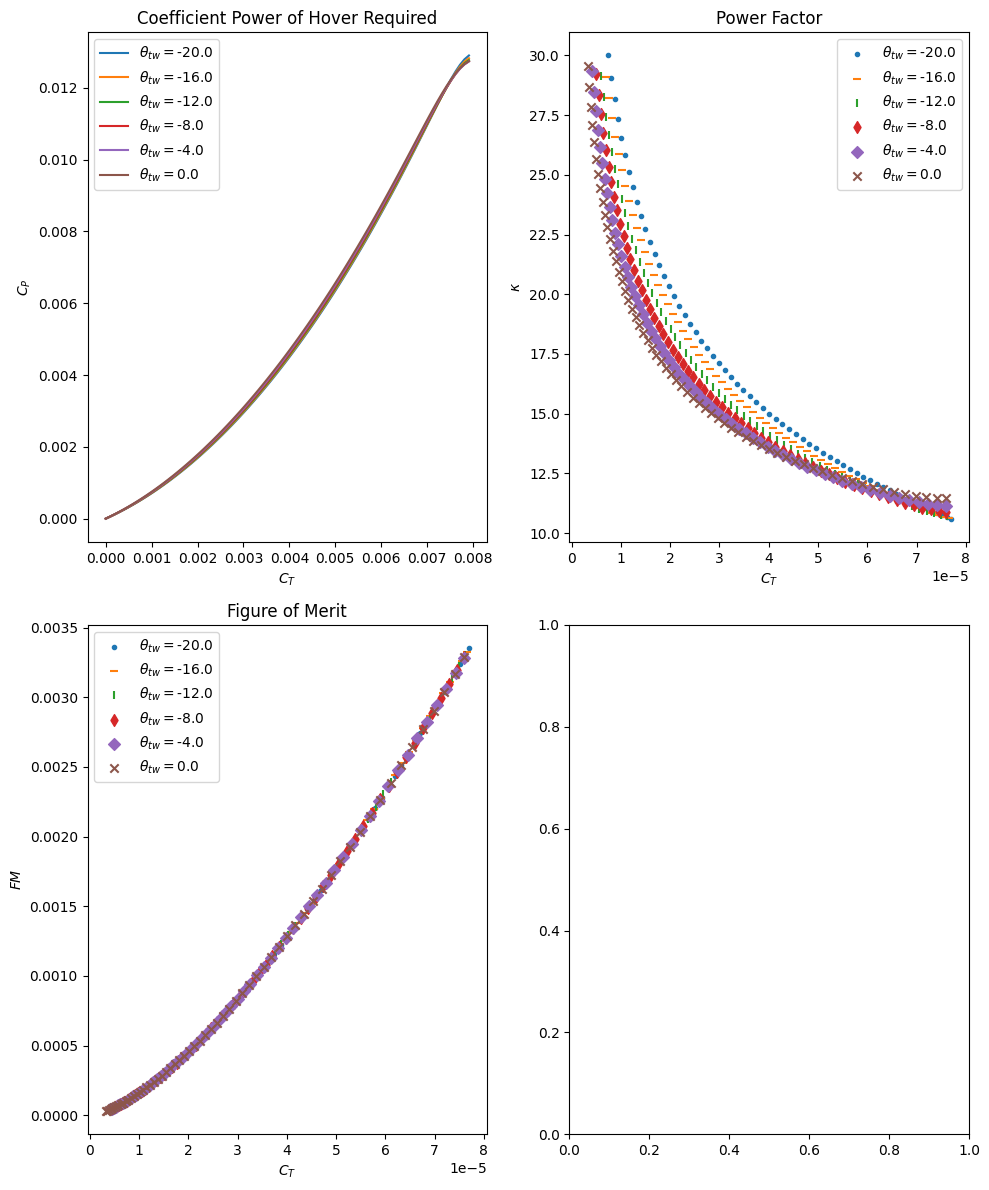

In [5]:
PlotProblem4()

/home/bigchungus/Documents/Github/School24/Aero 455/hw-3/Problem2.py:54: RuntimeWarning: invalid value encountered in arccos
  return (2 / np.pi) * np.arccos(np.exp(-tip_loss_factor))
/home/bigchungus/Documents/Github/School24/Aero 455/hw-3/Problem2.py:54: RuntimeWarning: overflow encountered in exp
  return (2 / np.pi) * np.arccos(np.exp(-tip_loss_factor))


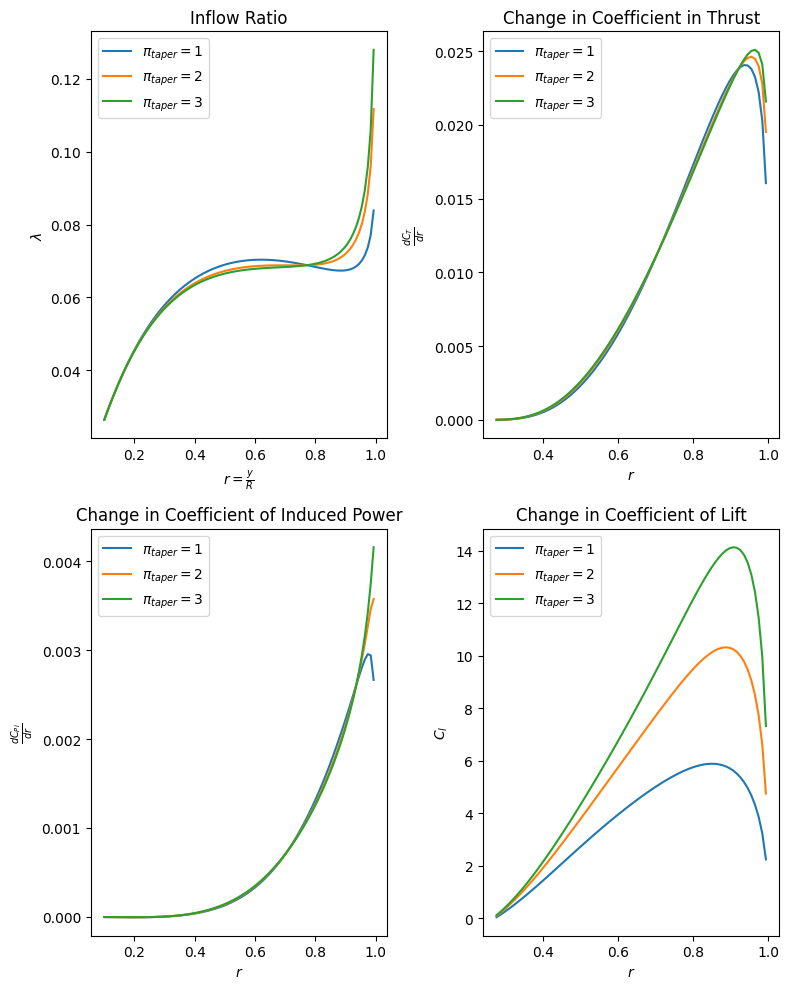

In [6]:
PlotProblem5()

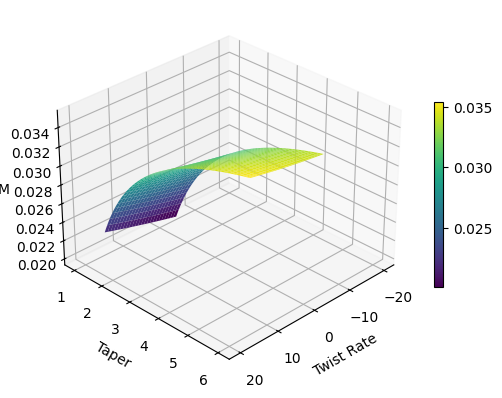

In [7]:
FigureOfMerit3DPlot()